<a href="https://colab.research.google.com/github/niruthikka24/DataStorm-3.0/blob/main/DataStorm_3_0_Day_2_RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using XGBoost and Random Forest Regressor for Weekly Sales Predictions

In [1]:
from google.colab import files
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
uploaded = files.upload()

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Saving validation_data.csv to validation_data.csv


In [3]:
df = pd.read_csv('train_data.csv')
df.head()

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


Replacing the outliers in the DailySales column using inter quartile range

In [4]:
Q1 = df['DailySales'].quantile(0.25)
Q3 = df['DailySales'].quantile(0.75)
IQR = Q3 - Q1
whisker_width = 3
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
df['DailySales']=np.where(df['DailySales']>upper_whisker,upper_whisker,np.where(df['DailySales']<lower_whisker,lower_whisker,df['DailySales']))

Changing the datatype of the 'DateID' column and Label Encoding for the Categorical Variable 'CategoryCode'

In [5]:
df['DateID'] = pd.to_datetime(df['DateID'])
scale_mapper = {"category_1":1, "category_2":2, "category_3":3,"category_4":4}
df["Category"] = df["CategoryCode"].replace(scale_mapper)
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Category
0,category_2,117610,2021-11-06,7.0,2
1,category_4,836584,2021-11-18,16.0,4
2,category_1,370195,2022-01-24,6.0,1
3,category_2,172582,2021-10-30,5.0,2
4,category_2,1006009,2021-10-30,5.0,2


Adding additional features using the DateID

In [6]:
df['year'] = df.DateID.dt.year
df['month'] = df.DateID.dt.month
df['weekofyear'] = df.DateID.dt.weekofyear
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,CategoryCode,ItemCode,DateID,DailySales,Category,year,month,weekofyear
0,category_2,117610,2021-11-06,7.0,2,2021,11,44
1,category_4,836584,2021-11-18,16.0,4,2021,11,46
2,category_1,370195,2022-01-24,6.0,1,2022,1,4
3,category_2,172582,2021-10-30,5.0,2,2021,10,43
4,category_2,1006009,2021-10-30,5.0,2,2021,10,43


Computing WeeklySales values, since the problem demands predictions for the next 4 weeks.

In [7]:
df['WeeklySales']  = df.groupby(['Category','ItemCode','weekofyear'])['DailySales'].transform('sum')
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Category,year,month,weekofyear,WeeklySales
0,category_2,117610,2021-11-06,7.0,2,2021,11,44,65.0
1,category_4,836584,2021-11-18,16.0,4,2021,11,46,102.0
2,category_1,370195,2022-01-24,6.0,1,2022,1,4,37.0
3,category_2,172582,2021-10-30,5.0,2,2021,10,43,26.0
4,category_2,1006009,2021-10-30,5.0,2,2021,10,43,13.0


In [8]:
df.shape

(19921, 9)

Adding an additional feature that indicates the week of the month.

In [9]:
weeks_no=[]
for i in df['weekofyear']:
  w=i%4
  weeks_no.append(w)

d2 = pd.Series(weeks_no,name='week_of_month')
df=pd.concat([df, d2], axis=1)
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Category,year,month,weekofyear,WeeklySales,week_of_month
0,category_2,117610,2021-11-06,7.0,2,2021,11,44,65.0,0
1,category_4,836584,2021-11-18,16.0,4,2021,11,46,102.0,2
2,category_1,370195,2022-01-24,6.0,1,2022,1,4,37.0,0
3,category_2,172582,2021-10-30,5.0,2,2021,10,43,26.0,3
4,category_2,1006009,2021-10-30,5.0,2,2021,10,43,13.0,3


In [10]:
df.drop(['DateID','DailySales','CategoryCode'],axis=1,inplace=True)
df = df.drop_duplicates()
df.shape

(4278, 7)

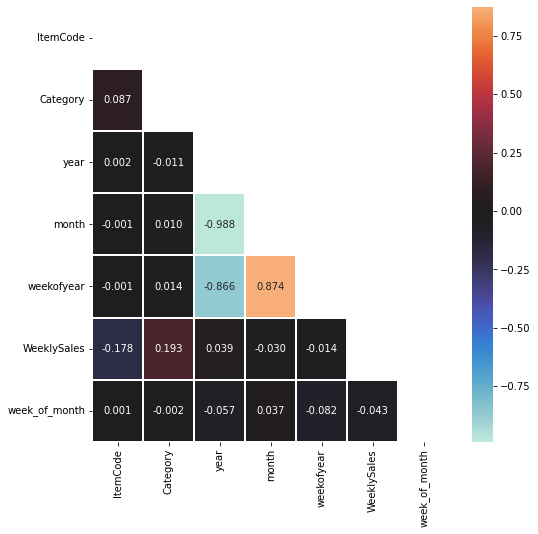

In [11]:
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Add the mask to the heatmap
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(corr, mask=mask,  center=0, linewidths=1, annot=True, fmt=".3f", ax = ax)
plt.show()

While preprocessing the validation and test datasets, the labels for the Week column are replaced with the starting week of that week in order to compute the year, month and week of year values.

In [12]:
#preprocessing the validation and testing data sets
def preprocessDataSet(df):
  scale_mapper = {"category_1":1, "category_2":2, "category_3":3,"category_4":4}
  df["Category"] = df["CategoryCode"].replace(scale_mapper)
  scale_mapper1 = {"w1":'2022-02-14', "w2":'2022-02-21', "w3":'2022-02-28',"w4":'2022-03-07'}
  df["DateID"] = df["Week"].replace(scale_mapper1)
  df['DateID'] = pd.to_datetime(df['DateID'])
  df['year'] = df.DateID.dt.year
  df['month'] = df.DateID.dt.month
  df['weekofyear'] = df.DateID.dt.weekofyear
  df.drop(['Week','CategoryCode','DateID'],axis=1,inplace=True)

In [13]:
valdf = pd.read_csv('validation_data.csv')
valdf.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [14]:
preprocessDataSet(valdf)
valdf.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


,ItemCode,WeeklySales,Category,year,month,weekofyear
0,1044502,11,2,2022,2,7
1,1105009,11,2,2022,2,7
2,913561,5,2,2022,3,10
3,1048975,30,1,2022,3,10
4,17287,60,1,2022,2,8


In [15]:
weeks_no=[]
for i in valdf['weekofyear']:
  w=i%4
  weeks_no.append(w)

d2 = pd.Series(weeks_no,name='week_of_month')
valdf=pd.concat([valdf, d2], axis=1)
valdf.head()

,ItemCode,WeeklySales,Category,year,month,weekofyear,week_of_month
0,1044502,11,2,2022,2,7,3
1,1105009,11,2,2022,2,7,3
2,913561,5,2,2022,3,10,2
3,1048975,30,1,2022,3,10,2
4,17287,60,1,2022,2,8,0


In [16]:
trainx = df.drop(['WeeklySales'],axis=1)
trainy = df['WeeklySales']
trainy.head()

0     65.0
1    102.0
2     37.0
3     26.0
4     13.0
Name: WeeklySales, dtype: float64

Using XGBClassifier and XGBRegressor

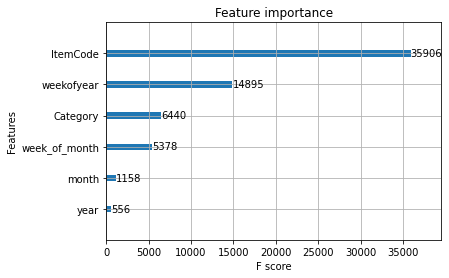

In [17]:
cmodel = XGBClassifier()
cmodel.fit(trainx, trainy)
# plot feature importance
plot_importance(cmodel)
plt.show()

In [18]:
model = XGBRegressor()
model.fit(trainx, trainy)

[18:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [19]:
testx = valdf.drop(['WeeklySales'],axis=1)
testy = valdf["WeeklySales"]

In [20]:
pred = cmodel.predict(testx)

MAPE score is used to measure the predictions' accuracy

In [21]:
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
LR_MAPE= mape(testy, pred)
print("MAPE: ",LR_MAPE)

MAPE:  64.72902960898487


In [22]:
xgb_r = XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
xgb_r.fit(trainx, trainy)
pred2 = xgb_r.predict(testx)
LR_MAPE= mape(testy, pred2)
print("MAPE: ",LR_MAPE)

[18:05:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE:  86.41067768708554


Dropping the month and year columns that had low correlation with the WeeklySales. (These columns also had low scores in XGBoost's feature importance)

In [23]:
trainx2 = trainx.drop(['month','year'],axis=1)
print(trainx2.head())
testx2 = testx.drop(['month','year'],axis=1)
print(testx2.head())

   ItemCode  Category  weekofyear  week_of_month
0    117610         2          44              0
1    836584         4          46              2
2    370195         1           4              0
3    172582         2          43              3
4   1006009         2          43              3
   ItemCode  Category  weekofyear  week_of_month
0   1044502         2           7              3
1   1105009         2           7              3
2    913561         2          10              2
3   1048975         1          10              2
4     17287         1           8              0


In [24]:
cmodel2 = XGBClassifier()
cmodel2.fit(trainx2, trainy)
pred2 = cmodel2.predict(testx2)
LR_MAPE2= mape(testy, pred2)
print("MAPE: ",LR_MAPE2)

MAPE:  68.4134648421722


In [25]:
rmodel = XGBRegressor()
rmodel.fit(trainx2, trainy)
pred3 = rmodel.predict(testx2)
LR_MAPE3= mape(testy, pred3)
print("MAPE: ",LR_MAPE3)

[18:06:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE:  103.73182999770631


In [26]:
xgb_r = XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)
xgb_r.fit(trainx2, trainy)
pred3 = xgb_r.predict(testx2)
LR_MAPE3= mape(testy, pred3)
print("MAPE: ",LR_MAPE3)

[18:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE:  86.41067768708554


In [ ]:
n_estimators = [500,1000,2000]
max_depth = [10,50,100]
min_child_weight = [1,2]
gamma = [1,5]
learning_rate = [0.1,0.05,0.01]

for n in n_estimators:
  for m in max_depth:
    for l in learning_rate:
      model = XGBClassifier(learning_rate=l,n_estimators=n,max_depth=m)
      model.fit(trainx2, trainy)
      pred = model.predict(testx2)
      LR_MAPE3= mape(testy, pred3)
      print("n_estimator = %d, max_depth = %d, learning_rate = %f MAPE: %f" % (n,m,l,LR_MAPE3))


In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 scale_pos_weight=1,
 seed=27)
xgb1.fit(trainx2, trainy)
pred3 = xgb1.predict(testx2)
LR_MAPE3= mape(testy, pred3)
print("MAPE: ",LR_MAPE3)

MAPE:  74.08373735594428


Using Random Forest Regressor

In [27]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(trainx2,trainy)
rpred = regressor.predict(testx2)
LR_MAPE3= mape(testy, rpred)
print("MAPE: ",LR_MAPE3)

MAPE:  65.89957196891122


In [ ]:
from sklearn.model_selection import GridSearchCV

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(trainx2, trainy)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, testx2, testy)

In [31]:
for n in [5,8,12,15,16,20,25,50,75]:
  regressor = RandomForestRegressor(n_estimators = n, random_state = 0)
  regressor.fit(trainx2,trainy)
  rpred = regressor.predict(testx2)
  LR_MAPE3= mape(testy, rpred)
  print("n-estimator: ",n)
  print("MAPE: ",LR_MAPE3)

n-estimator:  5
MAPE:  66.97891618037119
n-estimator:  8
MAPE:  64.48569190111485
n-estimator:  12
MAPE:  66.11289944156901
n-estimator:  15
MAPE:  64.60916677998038
n-estimator:  16
MAPE:  64.31891748334513
n-estimator:  20
MAPE:  64.84941500863276
n-estimator:  25
MAPE:  66.43384085078169
n-estimator:  50
MAPE:  65.82072379045678
n-estimator:  75
MAPE:  64.81144536334877


In [32]:
for m in [80, 90, 100, 110]:
  regressor = RandomForestRegressor(n_estimators = 16, random_state = 0, max_depth = m)
  regressor.fit(trainx2,trainy)
  rpred = regressor.predict(testx2)
  LR_MAPE3= mape(testy, rpred)
  print("max_depth: ",m)
  print("MAPE: ",LR_MAPE3)

max_depth:  80
MAPE:  64.31891748334513
max_depth:  90
MAPE:  64.31891748334513
max_depth:  100
MAPE:  64.31891748334513
max_depth:  110
MAPE:  64.31891748334513


In [33]:
reg = RandomForestRegressor(n_estimators = 16, random_state = 0)
reg.fit(trainx2,trainy)
regpred = reg.predict(testx2)
LR_MAPEreg= mape(testy, regpred)
print("MAPE: ",LR_MAPEreg)

MAPE:  64.31891748334513


In [34]:
regfo = RandomForestRegressor(n_estimators = 1000, random_state = 0)
regfo.fit(trainx2,trainy)
regpredfo = regfo.predict(testx2)
LR_MAPEreg= mape(testy, regpredfo)
print("MAPE: ",LR_MAPEreg)

MAPE:  63.806911029903226


Feature Importance Plot for Random Forest Regressor

In [35]:
print(trainx.head())
print(testx.head())

   ItemCode  Category  year  month  weekofyear  week_of_month
0    117610         2  2021     11          44              0
1    836584         4  2021     11          46              2
2    370195         1  2022      1           4              0
3    172582         2  2021     10          43              3
4   1006009         2  2021     10          43              3
   ItemCode  Category  year  month  weekofyear  week_of_month
0   1044502         2  2022      2           7              3
1   1105009         2  2022      2           7              3
2    913561         2  2022      3          10              2
3   1048975         1  2022      3          10              2
4     17287         1  2022      2           8              0


In [36]:
rf = RandomForestRegressor(n_estimators = 15, random_state = 0)
rf.fit(trainx, trainy)
rf.feature_importances_

array([0.70995988, 0.11934236, 0.00811719, 0.02128521, 0.1104633 ,
       0.03083206])

<BarContainer object of 6 artists>

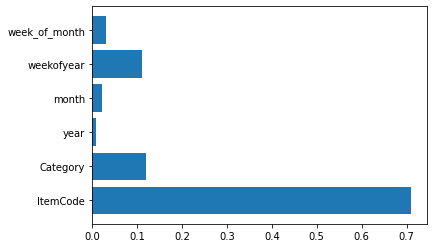

In [37]:
plt.barh(trainx.columns, rf.feature_importances_)

According to the above feature importance plot, the features week_of_month, month and year are dropped.

In [38]:
trainx3 = trainx.drop(['month','week_of_month','year'],axis=1)
testx3 = testx.drop(['month','week_of_month','year'],axis=1)
print(trainx3.head())
print(testx3.head())

   ItemCode  Category  weekofyear
0    117610         2          44
1    836584         4          46
2    370195         1           4
3    172582         2          43
4   1006009         2          43
   ItemCode  Category  weekofyear
0   1044502         2           7
1   1105009         2           7
2    913561         2          10
3   1048975         1          10
4     17287         1           8


In [39]:
rf = RandomForestRegressor(n_estimators = 15, random_state = 0)
rf.fit(trainx3, trainy)
rfpred = rf.predict(testx3)
LR_MAPErf= mape(testy, rfpred)
print("MAPE: ",LR_MAPErf)

MAPE:  61.44466536323496


Hyper Parameter Tuning for the above Random Forest Regressor model

In [40]:
for n in [5,8,9,10,11,12,20,30]:
  regressor = RandomForestRegressor(n_estimators = n, random_state = 0)
  regressor.fit(trainx3,trainy)
  rpred = regressor.predict(testx3)
  LR_MAPE3= mape(testy, rpred)
  print("n-estimator: ",n)
  print("MAPE: ",LR_MAPE3)

n-estimator:  5
MAPE:  62.3518069935065
n-estimator:  8
MAPE:  60.82504672610726
n-estimator:  9
MAPE:  59.830366210301236
n-estimator:  10
MAPE:  61.42909613337193
n-estimator:  11
MAPE:  60.982329957453295
n-estimator:  12
MAPE:  60.77509176086473
n-estimator:  20
MAPE:  60.57827084064282
n-estimator:  30
MAPE:  60.54763016029688


Getting the predictions for Test Data Set Using the Best Random Forest Regressor Model identified (n_estimators = 9) with Reduced Features

In [41]:
testdf = pd.read_csv('test_data.csv')

In [42]:
def preprocessTestDataSet(df):
  scale_mapper = {"category_1":1, "category_2":2, "category_3":3,"category_4":4}
  df["Category"] = df["CategoryCode"].replace(scale_mapper)
  scale_mapper1 = {"w1":'2022-02-14', "w2":'2022-02-21', "w3":'2022-02-28',"w4":'2022-03-07'}
  df["DateID"] = df["Week"].replace(scale_mapper1)
  df['DateID'] = pd.to_datetime(df['DateID'])
  df['weekofyear'] = df.DateID.dt.weekofyear
  df.drop(['DateID'],axis=1,inplace=True)

In [43]:
preprocessTestDataSet(testdf)
testdf.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


,CategoryCode,ItemCode,Week,PredictedSales,Category,weekofyear
0,category_1,43738,w4,NaN,1,10
1,category_2,1006090,w1,NaN,2,7
2,category_2,1076929,w4,NaN,2,10
3,category_1,1081321,w3,NaN,1,9
4,category_2,216151,w4,NaN,2,10


In [44]:
testdfx = testdf.drop(['PredictedSales','CategoryCode','Week'],axis=1)
testdfx.head()

,ItemCode,Category,weekofyear
0,43738,1,10
1,1006090,2,7
2,1076929,2,10
3,1081321,1,9
4,216151,2,10


In [45]:
rf = RandomForestRegressor(n_estimators = 9, random_state = 0)
rf.fit(trainx3, trainy)
rfpred = rf.predict(testx3)
LR_MAPErf= mape(testy, rfpred)
print("MAPE: ",LR_MAPErf)

MAPE:  59.830366210301236


In [ ]:
finpred = rf.predict(testdfx)
finpred

In [47]:
testdf['PredictedSales'] =finpred
testdf

,CategoryCode,ItemCode,Week,PredictedSales,Category,weekofyear
0,category_1,43738,w4,32.111111,1,10
1,category_2,1006090,w1,16.555556,2,7
2,category_2,1076929,w4,6.000000,2,10
3,category_1,1081321,w3,9.777778,1,9
4,category_2,216151,w4,12.444444,2,10
...,...,...,...,...,...,...
372,category_2,1101571,w1,12.000000,2,7
373,category_2,1090258,w4,22.666667,2,10
374,category_2,906595,w1,8.444444,2,7
375,category_2,32245,w1,50.111111,2,7


In [48]:
testdf.drop(['Category','weekofyear'],axis=1,inplace=True)


In [49]:
testdf['ID'] = testdf.agg('{0[CategoryCode]}_{0[ItemCode]}_{0[Week]}'.format, axis=1)
testdf.head()

,CategoryCode,ItemCode,Week,PredictedSales,ID
0,category_1,43738,w4,32.111111,category_1_43738_w4
1,category_2,1006090,w1,16.555556,category_2_1006090_w1
2,category_2,1076929,w4,6.000000,category_2_1076929_w4
3,category_1,1081321,w3,9.777778,category_1_1081321_w3
4,category_2,216151,w4,12.444444,category_2_216151_w4


In [ ]:
testdf.to_csv('test_datafin.csv') 
files.download('test_datafin.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>